### import the libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### utility functions (no change is needed in this section)

In [2]:
def show_images(*images, titles=None):
    """
    Displays multiple images using matplotlib.

    Args:
        *images: Variable length image list to display.
        titles (list, optional): Titles for each subplot. Defaults to None.

    Returns:
        None
    """
    num_images = len(images)
    plt.figure(figsize=(15, 12))

    for i, image in enumerate(images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if titles:
            plt.title(titles[i])
        plt.axis('off')

    plt.show()

In [3]:
def draw_corners_on_image(image, corners, neighborhood_size):
    """
    Draws circles on the original image at detected corner locations.

    Args:
        image (numpy.ndarray): Original image.
        corners (numpy.ndarray): Binary image with corner detections.
        neighborhood_size (int): Size of the neighborhood used for corner detection.

    Returns:
        numpy.ndarray: Image with corners marked.
    """
    height, width = image.shape[:2]
    offset = neighborhood_size // 2

    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            if corners[y, x] == 255:
                cv2.circle(image, (x, y), 5, (255, 0, 0), -1)

    return image

In [4]:
def draw_matches(img1, img2, kp1, kp2, matches):
    """
    Draws matches between keypoints of two images.

    Args:
        img1 (numpy.ndarray): First image.
        img2 (numpy.ndarray): Second image.
        kp1 (list): Keypoints in the first image.
        kp2 (list): Keypoints in the second image.
        matches (list): List of matched keypoints.

    Returns:
        numpy.ndarray: Image with matches drawn.
    """
    return cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

### image stitching

In [20]:
def sift_feature_matching(img1, img2):
    """
    Performs SIFT feature detection and matching between two images.

    Args:
        img1 (numpy.ndarray): First grayscale image.
        img2 (numpy.ndarray): Second grayscale image.

    Returns:
        tuple: Source points, destination points, and image with matches drawn.
    """
    #############
    # YOUR CODE #
    #############
    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)

    matches = bf.knnMatch(des1, des2, k = 2)

    good_matches = []
    src_pts = []
    dst_pts = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            src_pts.append(kp1[m.queryIdx].pt)
            dst_pts.append(kp2[m.trainIdx].pt)
    src_pts = np.float32(src_pts).reshape(-1, 1, 2)
    dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

    matched_img = draw_matches(img1, img2, kp1, kp2, good_matches)

    return src_pts, dst_pts, matched_img

In [21]:
def ransac_homography(src_pts, dst_pts, num_iterations=2000, threshold=4):
    """
    Computes the best homography matrix using RANSAC.

    Args:
        src_pts (numpy.ndarray): Source points from the first image.
        dst_pts (numpy.ndarray): Destination points from the second image.
        num_iterations (int): Number of RANSAC iterations. Default is 2000.
        threshold (float): Distance threshold to determine inliers. Default is 4.

    Returns:
        numpy.ndarray: Homography matrix.
    """
    best_H = None
    max_inliers = 0

    src_pts = src_pts.reshape(-1, 2)
    dst_pts = dst_pts.reshape(-1, 2)

    #############
    # YOUR CODE #
    #############
    n = src_pts.shape[0]
    if n < 4:
        return np.array([])

    for _ in range(num_iterations):
        idx = np.random.choice(n, 4, replace = False)
        src_sample = src_pts[idx]
        dst_sample = dst_pts[idx]

        H, _ = cv2.findHomography(src_sample, dst_sample, method = 0)
        if H is None:
            continue

        src_hom = np.concatenate([src_pts, np.ones((n, 1))], axis = 1)
        projected = np.dot(src_hom, H.T)
        projected = projected / projected[:, 2][:, np.newaxis]

        dists = np.linalg.norm(projected[:, :2] - dst_pts, axis = 1)
        inliers = dists < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            best_H = H
            max_inliers = num_inliers
    return best_H

In [22]:
def stitch_images(img1, img2, H):
    """
    Stitches two images together using a homography matrix.

    Args:
        img1 (numpy.ndarray): First image.
        img2 (numpy.ndarray): Second image.
        H (numpy.ndarray): Homography matrix.

    Returns:
        numpy.ndarray: Stitched image.
    """
    height, width = img2.shape[:2]

    corners_img1 = np.float32([[0, 0], [0, height], [width, height], [width, 0]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    corners_img2 = np.float32([[0, 0], [0, height], [width, height], [width, 0]]).reshape(-1, 1, 2)
    all_corners = np.concatenate((warped_corners, corners_img2), axis = 0)
    [xmin, ymin] = np.int32(all_corners.min(axis = 0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis = 0).ravel() + 0.5)
    tx, ty = -xmin, -ymin
    T = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])

    result_size =  (xmax - xmin, ymax - ymin)
    TH = np.dot(T, H)
    warped_img1 = cv2.warpPerspective(img1, TH, result_size)
    stitched_image = warped_img1.copy()
    stitched_image[ty:ty+height, tx:tx+width] = img2

    return stitched_image

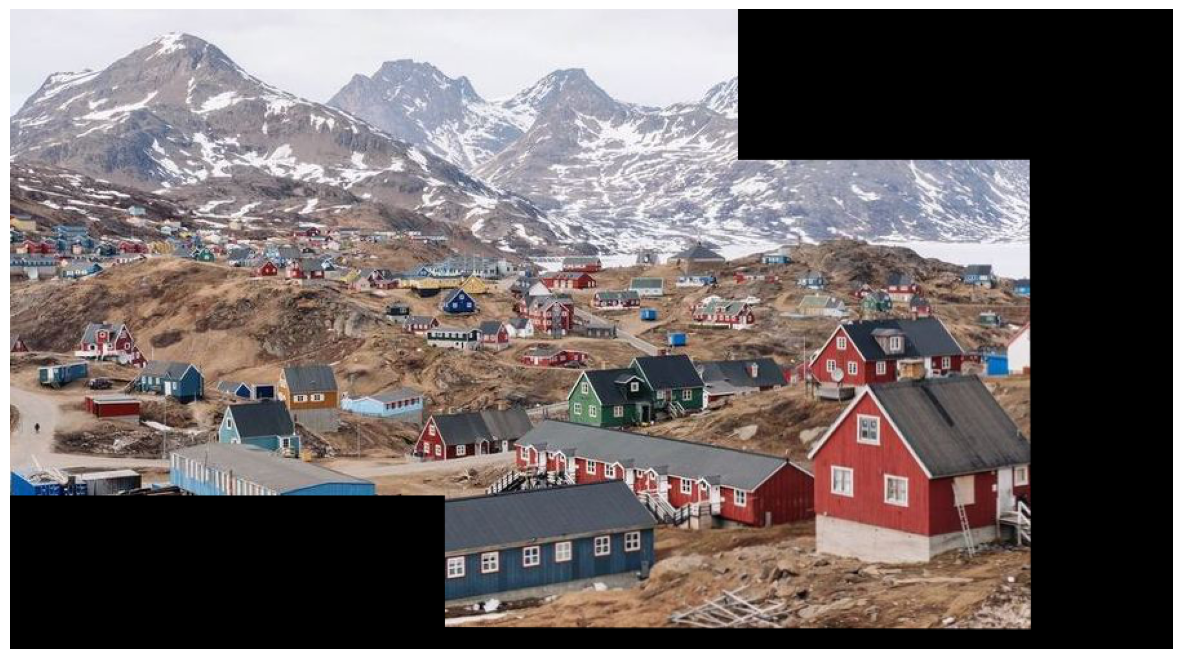

In [23]:
# Load images

left_path = "Q2-imgs/left.jpg"
right_path = "Q2-imgs/right.jpg"

img1 = cv2.imread(right_path)
img2 = cv2.imread(left_path)

# Convert images to grayscale

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# Extract features and matching points

src_pts, dst_pts, matched_img = sift_feature_matching(img1_gray, img2_gray)

# Find the best homography using RANSAC

best_H = ransac_homography(src_pts, dst_pts)

# Stitch images together

stitched_img = stitch_images(img1, img2, best_H)

# Display the matched keypoints and the final stitched image

show_images(stitched_img)